In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import recover_pose_from_homography, recover_pose_from_homography_v2
from src.measurement_data import load_measurements_from_yaml

## Function definition

In [3]:
def load_calibration_json(filename):
    with open(filename) as f:
        data = json.load(f)

    camera_matrix = np.array(data['camera_matrix'])
    dist_coeff = np.array(data['dist_coeff'])
    image_size = tuple(data['image_size'])

    return camera_matrix, dist_coeff, image_size

In [4]:
def load_rgb(path):
    """
    Load image from path and convert to RGB.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Image not found: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def extract_features(image, method='SIFT'):
    """
    Detect keypoints and compute descriptors.

    Args:
        image: RGB image as numpy array.
        method: Feature detector ('SIFT', 'ORB', etc.).
    Returns:
        keypoints, descriptors
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if method == 'SIFT':
        detector = cv2.SIFT_create()
    elif method == 'ORB':
        detector = cv2.ORB_create(nfeatures=2000)
    else:
        raise ValueError(f"Unsupported method: {method}")
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_descriptors(desc1, desc2, method='BF', cross_check=True):
    """
    Match feature descriptors between two images.

    Args:
        desc1: Descriptors from image 1.
        desc2: Descriptors from image 2.
        method: 'BF' for BruteForce, 'FLANN' for FLANN matcher.
        cross_check: (BF only) whether to use crossCheck.
    Returns:
        List of matches sorted by distance.
    """
    if method == 'BF':
        # Choose norm by descriptor type
        norm = cv2.NORM_L2 if desc1.dtype == np.float32 else cv2.NORM_HAMMING
        matcher = cv2.BFMatcher(norm, crossCheck=cross_check)
        matches = matcher.match(desc1, desc2)
    elif method == 'FLANN':
        # FLANN parameters for SIFT
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        raw_matches = matcher.knnMatch(desc1, desc2, k=2)
        # Ratio test
        matches = [m[0] for m in raw_matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]
    else:
        raise ValueError(f"Unsupported matcher: {method}")
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def compute_homography(kp1, kp2, matches, ransac_thresh=5.0):
    """
    Compute homography using matched keypoints.

    Args:
        kp1, kp2: Keypoints from image1 and image2.
        matches: List of cv2.DMatch objects.
        ransac_thresh: RANSAC reprojection threshold.
    Returns:
        homography matrix H, mask of inliers
    """
    if len(matches) < 4:
        raise ValueError("Not enough matches to compute homography")
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)
    return H, mask

In [5]:
def template_match(template_path, scene_path, extract_method='SIFT', match_method='BF'):
    tpl = load_rgb(template_path)
    img = load_rgb(scene_path)
    kp_t, desc_t = extract_features(tpl, method=extract_method)
    kp_i, desc_i = extract_features(img, method=extract_method)
    matches = match_descriptors(desc_t, desc_i, method=match_method)
    H, mask = compute_homography(kp_t, kp_i, matches)
    return H, mask, tpl.shape[:2]

In [6]:
def compute_distance(R, t_unscaled, width, height, template_real_length, template_pixel_length):
    """
    Compute the distances from the camera center to the center of a planar template.

    Parameters:
        R (np.ndarray): 3x3 rotation matrix from template to camera
        t_unscaled (np.ndarray): 3x1 translation vector (unscaled, from homography decomposition)
        width (float): Template width in real-world units (e.g., mm)
        height (float): Template height in real-world units (e.g., mm)

    Returns:
        float: distance from the camera to the template center.
    """
    # Define two points in the template's local coordinate system (known real-world distance between them)
    p_world1 = np.array([[0], [0], [0]])          # Top-left corner
    p_world2 = np.array([[width], [0], [0]])      # Top-right corner

    # Transform both into the camera coordinate system using unscaled t
    p_cam1 = R @ p_world1 + t_unscaled
    p_cam2 = R @ p_world2 + t_unscaled

    # Compute the distance between the transformed points
    cam_distance = np.linalg.norm(p_cam2 - p_cam1)

    # Compute scale factor to align camera space with real-world distance
    real_distance = width
    scale = real_distance / cam_distance

    # Compute the scale factor based on the template's real-world length and pixel length
    scale_factor = template_real_length / template_pixel_length

    # Apply scale to the translation vector
    t_scaled = t_unscaled * scale

    # Template center
    center_world = np.array([width / 2, height / 2, 0]).reshape(3, 1)
    center_cam = R @ center_world + t_scaled
    center_distance = np.linalg.norm(center_cam)

    return center_distance * scale_factor

In [7]:
def compute_distance_correct(R, t_unscaled, width, height, template_real_length, template_pixel_length):
    # Method 1: Scale the translation directly using the template pixel/real ratio
    pixel_to_real_scale = template_real_length / template_pixel_length
    t_scaled = t_unscaled * pixel_to_real_scale
    
    # Template center in world coordinates
    center_world = np.array([width / 2, height / 2, 0]).reshape(3, 1)
    
    # Transform to camera coordinates
    center_cam = R @ center_world + t_scaled
    
    # Distance is simply the norm
    return np.linalg.norm(center_cam)

In [8]:
def compute_distance_correct_v2(R, t_unscaled, width, height, template_real_length, template_pixel_length):
    # Use the corner points method to find the correct scale
    p_world1 = np.array([[0], [0], [0]])
    p_world2 = np.array([[width], [0], [0]])
    
    # Transform using unscaled translation
    p_cam1 = R @ p_world1 + t_unscaled
    p_cam2 = R @ p_world2 + t_unscaled
    
    # The scale should be applied to the ENTIRE camera coordinate system
    cam_distance = np.linalg.norm(p_cam2 - p_cam1)
    scale = width / cam_distance
    
    # Template center
    center_world = np.array([width / 2, height / 2, 0]).reshape(3, 1)
    center_cam_unscaled = R @ center_world + t_unscaled
    
    # Scale the final distance, not the translation vector
    return np.linalg.norm(center_cam_unscaled) * scale

## Analysis

In [9]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

In [10]:
# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

In [11]:
scenes = data.get_all_scenes()

In [12]:
from src.geometry import recover_pose_from_homography_v3


def analyze_scene(scene_id, scenes, K):
    """
    This function analyzes a scene by executing the following steps:

    1. Load the scene and the corresponding templates.
    2. For each template, perform template matching against the scene image.
    3. Compute the homography and recover the camera pose.
    4. Compute the distance from the center of each template to the camera.
    5. Return the results including the template ID, homography, camera pose, and distance.
    """
    # Load scene and templates
    scene = data.get_scene(scene_id)
    templates = [data.get_template(t_id) for t_id in scenes[scene_id]]

    # Iterate over templates
    results = {}
    for template in templates:
        scene_path = os.path.join(project_root, scene.path)
        template_path = os.path.join(project_root, template.path)

        # Compute homography
        H, mask, t_shape = template_match(template_path, scene_path, extract_method='SIFT', match_method='BF')

        # Compute the condition number of the homography
        cond_num = np.linalg.cond(H)

        # Recover camera pose from homography
        # R, t = recover_pose_from_homography(H, K)
        R, t = recover_pose_from_homography_v3(H, K)

        # Compute the distance from the camera to the template center
        distance_pred = compute_distance(
            R=R,
            t_unscaled=t,
            width=template.width,
            height=template.height,
            template_real_length=template.height,
            template_pixel_length=t_shape[0]
        )

        # True distance and error
        distance_true = scene.get_distance('Camera', template.id).distance
        error = np.abs(distance_pred - distance_true)
        error_percent = (error / distance_true) * 100

        results[template.id] = {
            'homography': H.tolist(),
            'rotation': R.tolist(),
            'translation': t.tolist(),
            'distance_pred': distance_pred,
            'distance_true': distance_true,
            'error': error,
            'error_percent': error_percent,
            'condition_number': cond_num
        }
    return results

In [13]:
def analyze_scenes(scenes, K):
    """
    Analyze all scenes and return results.
    """
    all_results = {}
    for scene_id in scenes:
        print(f"Analyzing scene {scene_id}...")
        results = analyze_scene(scene_id, scenes, K)
        all_results[scene_id] = results
    return all_results

In [14]:
results = analyze_scenes(scenes, K)

Analyzing scene S0...
Analyzing scene S1...
Analyzing scene S2...
Analyzing scene S3...
Analyzing scene S4...
Analyzing scene S5...
Analyzing scene S6...
Analyzing scene S7...
Analyzing scene S8...


In [15]:
results

{'S0': {'T1': {'homography': [[0.4034760726560053,
     -0.010496649023223703,
     404.4289962271879],
    [0.01219505857117659, 0.3758126119335095, 489.3970964299097],
    [2.1758948612865587e-05, -2.952222418837416e-05, 0.9999999999999999]],
   'rotation': [[0.9987668786242727,
     0.007324116167965884,
     -0.049102744174696025],
    [-0.004007403495776317, 0.9977242264790769, 0.06730756728593],
    [0.04948396589148391, -0.06702779437730341, 0.9965232620970594]],
   'translation': [-0.08882159434369633,
    -0.1576374440931917,
    0.9834941714483207],
   'distance_pred': np.float64(26.095238952478237),
   'distance_true': 390.0,
   'error': np.float64(363.9047610475218),
   'error_percent': np.float64(93.30891308910815),
   'condition_number': np.float64(1024335.3040937046)}},
 'S1': {'T0': {'homography': [[0.17311424495740158,
     0.003681193584064367,
     386.6823260893821],
    [-0.007340912157654001, 0.18420041339795828, 620.4975077824821],
    [-1.2387107859506527e-05, 8

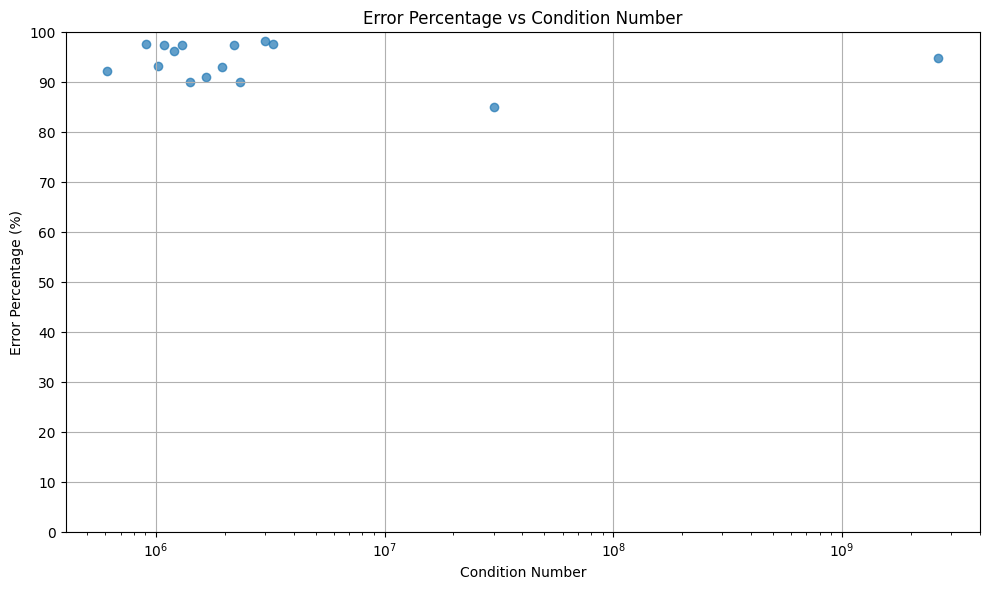

In [16]:
# Extract the error percentage and the condition number, and create a plot of the two against each other
error_percentages = []
condition_numbers = []
for scene_id, templates in results.items():
    for template_id, data in templates.items():
        error_percentages.append(data['error_percent'])
        condition_numbers.append(data['condition_number'])

plt.figure(figsize=(10, 6))
plt.scatter(condition_numbers, error_percentages, alpha=0.7)
plt.title('Error Percentage vs Condition Number')
plt.xlabel('Condition Number')
plt.ylabel('Error Percentage (%)')
plt.yticks(np.arange(0, 101, 10))
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()